# Portfolio Construction & Analysis

This notebook is designed as a foundational starting point for analyzing financial asset returns, portfolio management, and risk assessment. It leverages popular libraries like pandas, numpy, yfinance, and matplotlib to conduct data retrieval, statistical analysis, portfolio optimization, and visualizations. Features such as Sharpe ratio calculation, scenario simulations, and portfolio strategies like Constant Proportion Portfolio Insurance (CPPI) are included.

While this script provides comprehensive tools for portfolio analysis, you may notice some redundancy in the functions or similar code patterns. This structure is intentional, serving as a prototype for future development. The goal would be to transform these tools into a cohesive Python package, which will involve refactoring and optimizing the code for modularity, efficiency, and reusability. As such, these redundancies will be addressed to create generalized, robust methods suitable for real-world application.

In [158]:
import scipy.stats as stats
from scipy.stats import jarque_bera
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import ipywidgets as widgets
from IPython.display import display

# Configure the plot style
plt.style.use('ggplot')

---
### I — Price Series Retrieval

In [159]:
def AssetsPrices(Tickers, PriceType=None, Period="1mo", Interval="1d"):
    """
    Retrieves price data for given tickers from Yahoo Finance.

    Parameters:
    - Tickers: list of stock symbols.
    - PriceType: type of price ('Open', 'Close', etc.). If None, all price types are returned.
    - Period: data period (e.g., '1mo', '1y').
    - Interval: data interval (e.g., '1d', '1wk').

    Returns:
    - A DataFrame containing the requested price data.
    """
    if isinstance(Tickers, str):
        Tickers = [Tickers]
    
    DataFrames = []
    for Ticker in Tickers:
        Stock = yf.Ticker(Ticker)
        PricesDF = Stock.history(period=Period, interval=Interval)
        
        if PriceType:
            if PriceType not in PricesDF.columns:
                raise ValueError(f"PriceType '{PriceType}' is not valid for {Ticker}. Choose from {list(PricesDF.columns)}")
            PricesDF = PricesDF[[PriceType]].rename(columns={PriceType: Ticker})
        else:
            PricesDF = PricesDF.rename(columns=lambda col: f"{Ticker}{col}")
        
        DataFrames.append(PricesDF)
    
    return pd.concat(DataFrames, axis=1)

In [160]:
Tickers = ['INTC', 'GM' , 'IBM', 'GE', 'F'] 
PriceType = 'Close'
Period = '5y'
Interval= '1d'

In [227]:
PricesDF=AssetsPrices(Tickers, PriceType, Period, Interval)

In [228]:
PricesDF.head(5)

,INTC,GM,IBM,GE,F
Date,,,,,
2019-10-16 00:00:00-04:00,46.012493,35.000710,107.248207,43.420620,7.248003
2019-10-17 00:00:00-04:00,45.494900,34.561405,101.323929,44.103634,7.279968
2019-10-18 00:00:00-04:00,45.056263,34.542305,101.195641,43.713348,7.423809
2019-10-21 00:00:00-04:00,45.731758,34.313103,100.056053,42.883957,7.334463
2019-10-22 00:00:00-04:00,45.626480,34.676006,101.097519,44.201210,7.366953


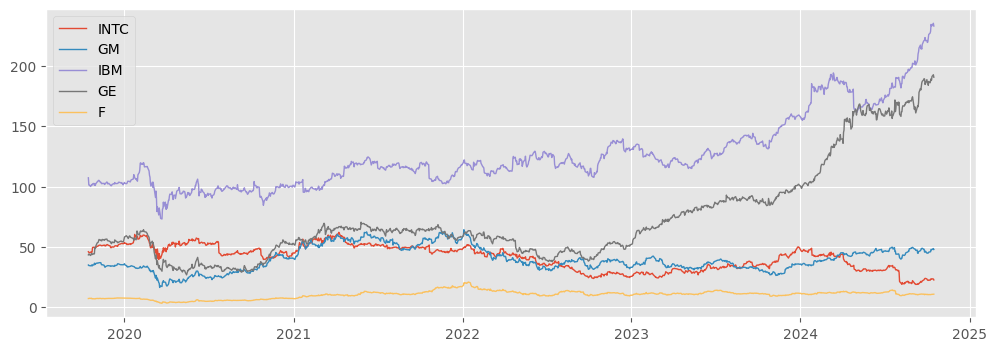

In [229]:
plt.figure(figsize=(12,4))
plt.plot(PricesDF, label=Tickers, linewidth=1)
plt.legend()
plt.show()

---
### II — Return Calculations

In [162]:
def AssetsReturns(Tickers, PriceType, Period, Interval):
    """
    Calculates daily returns for given tickers.

    Parameters:
    - Tickers: list of stock symbols.
    - PriceType: type of price ('Open', 'Close', etc.).
    - Period: data period.
    - Interval: data interval.

    Returns:
    - A DataFrame containing daily returns.
    """
    PricesDF = AssetsPrices(Tickers, PriceType, Period, Interval)
    ReturnsDF = PricesDF.pct_change().dropna()
    return ReturnsDF

In [163]:
ReturnsDF=AssetsReturns(Tickers, PriceType, Period, Interval)
ReturnsDF.head(5)

,INTC,GM,IBM,GE,F
Date,,,,,
2019-10-17 00:00:00-04:00,-0.011249,-0.012551,-0.055239,0.015730,0.004410
2019-10-18 00:00:00-04:00,-0.009641,-0.000553,-0.001266,-0.008850,0.019759
2019-10-21 00:00:00-04:00,0.014992,-0.006635,-0.011261,-0.018973,-0.012035
2019-10-22 00:00:00-04:00,-0.002302,0.010576,0.010409,0.030717,0.004430
2019-10-23 00:00:00-04:00,-0.005576,0.008262,0.003135,0.008830,0.015435


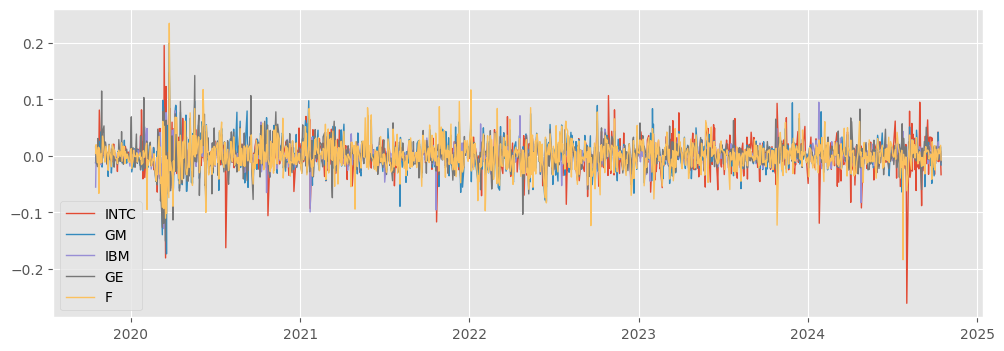

In [224]:
plt.figure(figsize=(12,4))
plt.plot(ReturnsDF, label=Tickers, linewidth=1)
plt.legend()
plt.show()

---
### III — Compounded Returns Calculations

In [164]:
def AssetsCompoundedReturns(Tickers, PriceType, Period, Interval):
    """
    Calculates compounded returns for given tickers.

    Parameters:
    - Tickers: list of stock symbols.
    - PriceType: type of price ('Open', 'Close', etc.).
    - Period: data period.
    - Interval: data interval.

    Returns:
    - A DataFrame containing compounded returns.
    """
    ReturnsDF = AssetsReturns(Tickers, PriceType, Period, Interval)
    CompoundedReturns = np.expm1(np.log1p(ReturnsDF).sum())
    return CompoundedReturns

In [165]:
CompoundedReturns = AssetsCompoundedReturns(Tickers, PriceType, Period, Interval)
display(CompoundedReturns)

INTC   -0.507525
GM      0.367115
IBM     1.172157
GE      3.388930
F       0.495584
dtype: float64

--- 
### IV— Expected Returns Calculations

In [166]:
def AssetsExpectedReturns(Tickers, PriceType, Period, Interval):
    """
    Calculates expected annualized returns for given tickers.

    Parameters:
    - Tickers: list of stock symbols.
    - PriceType: type of price ('Open', 'Close', etc.).
    - Period: data period.
    - Interval: data interval.

    Returns:
    - A DataFrame containing expected returns for various time horizons.
    """
    # Get asset returns
    ReturnsDF = AssetsReturns(Tickers, PriceType, Period, Interval)
    ReturnsDF = ReturnsDF.dropna()
    
    # Determine annualization factor based on interval
    if Interval == '1d':
        AnnualFactor = 252  # Trading days per year
    elif Interval == '1wk':
        AnnualFactor = 52   # Weeks per year
    elif Interval == '1mo':
        AnnualFactor = 12   # Months per year
    else:
        raise ValueError(f"Interval '{Interval}' not supported for annualized returns.")
    
    # Calculate mean returns
    MeanReturns = ReturnsDF.mean()
    
    # Calculate annualized returns using compound growth
    AnnualReturns = (1 + MeanReturns) ** AnnualFactor - 1
    
    # Expected returns for different horizons with compound capitalization
    ExpectedReturnsDF = pd.DataFrame({
        '1mo': (1 + MeanReturns) ** (AnnualFactor / 12) - 1,
        '3mo': (1 + MeanReturns) ** (AnnualFactor / 4) - 1,
        '6mo': (1 + MeanReturns) ** (AnnualFactor / 2) - 1,
        '9mo': (1 + MeanReturns) ** (AnnualFactor * 3 / 4) - 1,
        '1y': AnnualReturns,
        '2y': (1 + AnnualReturns) ** 2 - 1,
        '3y': (1 + AnnualReturns) ** 3 - 1,
        '5y': (1 + AnnualReturns) ** 5 - 1,
        '10y': (1 + AnnualReturns) ** 10 - 1
    })
    
    # Set tickers as index
    ExpectedReturnsDF.index = Tickers
    
    return ExpectedReturnsDF.T

In [167]:
ExpectedReturns = AssetsExpectedReturns(Tickers, PriceType, Period, Interval)
display(ExpectedReturns)

,INTC,GM,IBM,GE,F
1mo,-0.004069,0.012880,0.016007,0.031717,0.014986
3mo,-0.012158,0.039139,0.048794,0.098200,0.045634
6mo,-0.024167,0.079810,0.099969,0.206043,0.093351
9mo,-0.036031,0.122072,0.153640,0.324477,0.143246
1y,-0.047751,0.165989,0.209931,0.454541,0.195417
2y,-0.093221,0.359530,0.463933,1.115689,0.429022
3y,-0.136521,0.585197,0.771258,2.077355,0.708277
5y,-0.217016,1.155123,1.593003,5.510725,1.441164
10y,-0.386936,3.644557,5.723662,41.389539,4.959284


--- 
### V — Skewness Calculation of the Returns Distribution

In [168]:
def AssetsReturnsSkewness(Tickers, PriceType, Period, Interval):
    """
    Calculates skewness of asset returns.

    Parameters:
    - Tickers: list of stock symbols.
    - PriceType: type of price ('Open', 'Close', etc.).
    - Period: data period.
    - Interval: data interval.

    Returns:
    - A Series containing skewness values for each ticker.
    """
    ReturnsDF = AssetsReturns(Tickers, PriceType, Period, Interval)
    SkewnessDF = ReturnsDF.skew()
    return SkewnessDF

In [169]:
ReturnsSkewness = AssetsReturnsSkewness(Tickers, PriceType, Period, Interval)
display(ReturnsSkewness)

INTC   -0.890220
GM      0.061116
IBM    -0.473332
GE      0.078834
F       0.152265
dtype: float64

---
### VI — Kurtosis Calculation of the Returns Distribution

In [170]:
def AssetsReturnsKurtosis(Tickers, PriceType, Period, Interval):
    """
    Calculates kurtosis of asset returns.

    Parameters:
    - Tickers: list of stock symbols.
    - PriceType: type of price ('Open', 'Close', etc.).
    - Period: data period.
    - Interval: data interval.

    Returns:
    - A Series containing kurtosis values for each ticker.
    """
    ReturnsDF = AssetsReturns(Tickers, PriceType, Period, Interval)
    KurtosisDF = ReturnsDF.kurtosis()
    return KurtosisDF

In [171]:
ReturnsKurtosis = AssetsReturnsKurtosis(Tickers, PriceType, Period, Interval)
display(ReturnsKurtosis)

INTC   13.341710
GM      5.748287
IBM    10.393701
GE      5.437422
F       7.161001
dtype: float64

---
### VII — Jarque-Bera Test for Normality on the Returns Distribution

In [172]:
def AssetsReturnsJarqueBera(Tickers, PriceType, Period, Interval, Alpha):
    """
    Performs the Jarque-Bera test on asset returns to check for normality.

    Parameters:
    - Tickers: list of stock symbols.
    - PriceType: type of price.
    - Period: data period.
    - Interval: data interval.
    - Alpha: significance level.

    Returns:
    - A DataFrame containing Jarque-Bera statistics and normality conclusion.
    """
    ReturnsDF = AssetsReturns(Tickers, PriceType, Period, Interval)
    JbStats = {}
    for Ticker in ReturnsDF.columns:
        JbStat, JbPvalue = jarque_bera(ReturnsDF[Ticker])
        Normality = JbPvalue > Alpha
        JbStats[Ticker] = {'JB Statistic': JbStat, 'JB p-value': JbPvalue, 'Normality': Normality}

    JbDF = pd.DataFrame(JbStats).T
    return JbDF

In [173]:
Alpha = 0.05

In [174]:
JarqueBera = AssetsReturnsJarqueBera(Tickers, PriceType, Period, Interval, Alpha)
display(JarqueBera)

,JB Statistic,JB p-value,Normality
INTC,9407.870019,0.000000,False
GM,1714.813170,0.000000,False
IBM,5654.801143,0.000000,False
GE,1534.809788,0.000000,False
F,2665.769447,0.000000,False


--- 
### VIII — Analysis of the Returns Distribution (Skewness, Kurtosis, Jarque-Bera)

In [230]:
def AssetsReturnsDistrib(Tickers, PriceType, Period, Interval, PlotHistogram=False, Alpha=0.05):
    """
    Analyzes the distribution of asset returns.

    Parameters:
    - Tickers: list of stock symbols.
    - PriceType: type of price.
    - Period: data period.
    - Interval: data interval.
    - PlotHistogram: if True, plots histograms of returns.
    - Alpha: significance level for normality test.

    Returns:
    - A DataFrame containing skewness, kurtosis, and Jarque-Bera test results.
    """
    ReturnsDF = AssetsReturns(Tickers, PriceType, Period, Interval)
    
    Skewness = ReturnsDF.skew()
    Kurtosis = ReturnsDF.kurtosis()

    JbStats = {}
    for Ticker in ReturnsDF.columns:
        JbStat, JbPvalue = jarque_bera(ReturnsDF[Ticker])
        Normality = JbPvalue > Alpha
        JbStats[Ticker] = {'JB Statistic': JbStat, 'JB p-value': JbPvalue, 'Normality': Normality}
    
    JbDF = pd.DataFrame(JbStats).T

    # Combine skewness, kurtosis, and Jarque-Bera test results
    AssetsReturnsDistrib = pd.concat([Skewness.rename('Skewness'), Kurtosis.rename('Kurtosis'), JbDF], axis=1)

    # Plot histograms if requested
    if PlotHistogram:
        for Ticker in ReturnsDF.columns:
            plt.figure(figsize=(12,4))
            ReturnsDF[Ticker].hist(bins=100, alpha=0.75)
            plt.title(f"Histogram of {Ticker} Returns")
            plt.xlabel("Returns")
            plt.ylabel("Frequency")
            plt.show()

    return AssetsReturnsDistrib

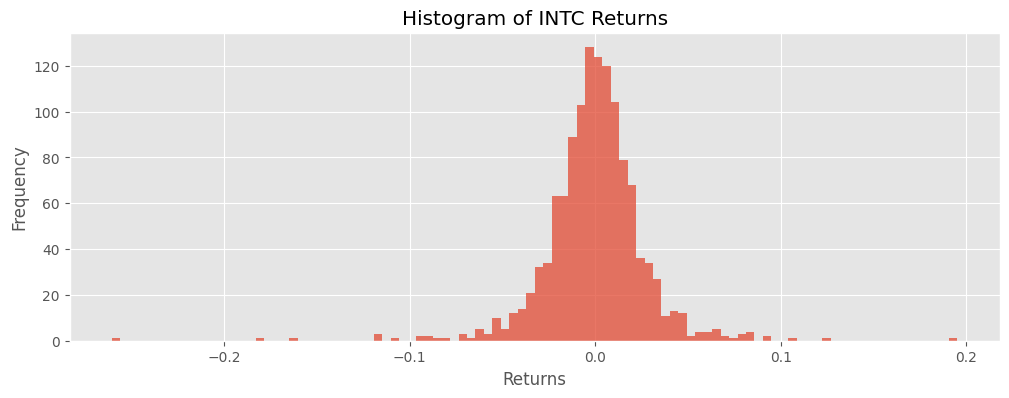

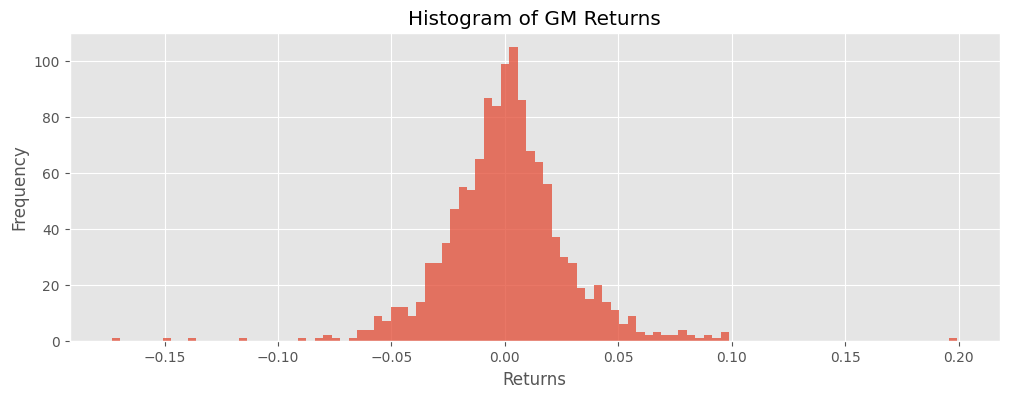

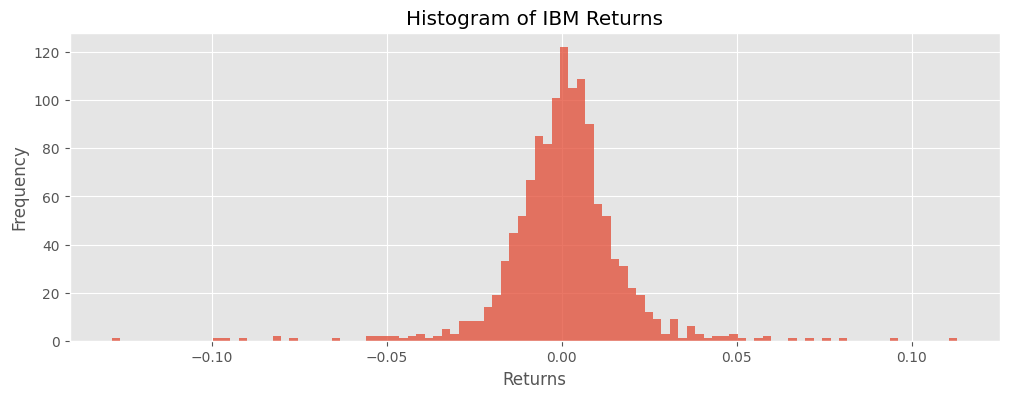

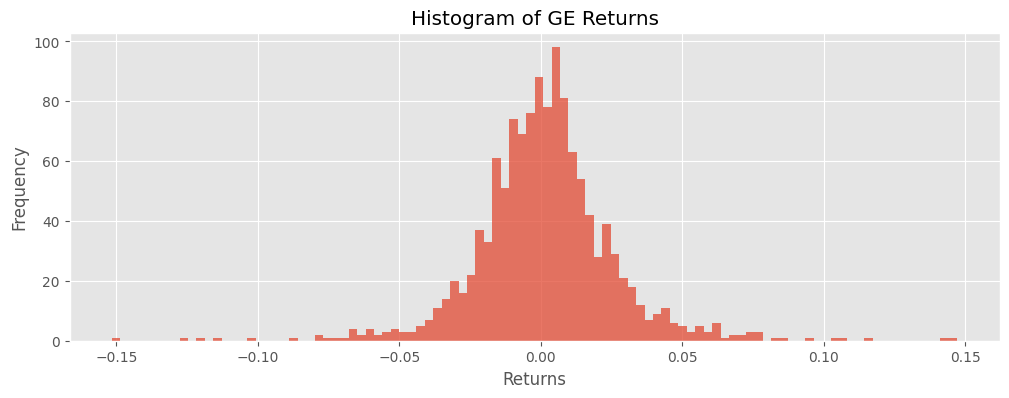

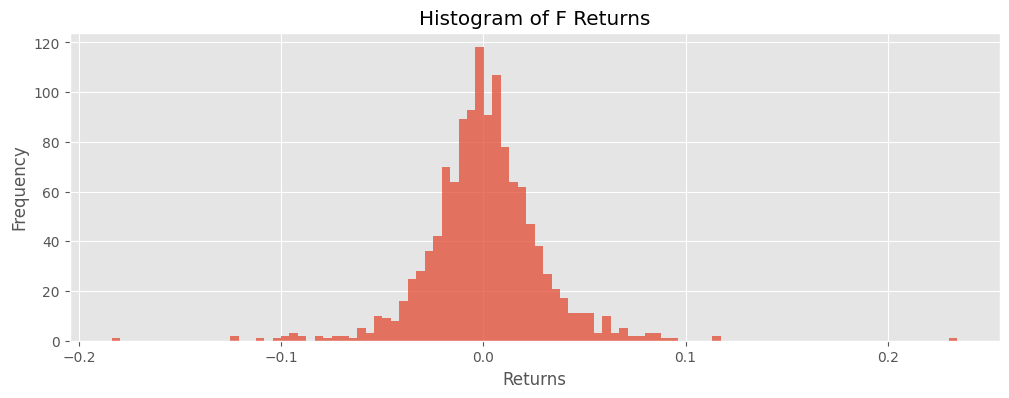

,Skewness,Kurtosis,JB Statistic,JB p-value,Normality
INTC,-0.890218,13.341723,9407.887097,0.000000,False
GM,0.061118,5.748304,1714.823382,0.000000,False
IBM,-0.473331,10.393689,5654.788822,0.000000,False
GE,0.078832,5.437416,1534.805895,0.000000,False
F,0.152265,7.161011,2665.776734,0.000000,False


In [231]:
AssetsReturnsDistrib(Tickers, PriceType, Period, Interval, PlotHistogram=True, Alpha=0.05)

--- 
### IX — Historical Volatility of Asset Returns

In [177]:
def AssetsHistoricalVolatility(Tickers, PriceType, Period, Interval):
    """
    Calculates historical annualized volatility of asset returns.

    Parameters:
    - Tickers: list of stock symbols.
    - PriceType: type of price.
    - Period: data period.
    - Interval: data interval.

    Returns:
    - A Series containing annualized volatility for each ticker.
    """
    ReturnsDF = AssetsReturns(Tickers, PriceType, Period, Interval)

    # Determine annualization factor based on interval
    if Interval == '1d':
        AnnualFactor = 252
    elif Interval == '1wk':
        AnnualFactor = 52
    elif Interval == '1mo':
        AnnualFactor = 12
    else:
        raise ValueError(f"Interval '{Interval}' not supported for annualized volatility.")

    # Calculate historical annualized volatility
    HistoricalVol = ReturnsDF.std() * np.sqrt(AnnualFactor)
    return HistoricalVol

In [178]:
HistoricalVolatilities=AssetsHistoricalVolatility(Tickers, PriceType, Period, Interval)
display(HistoricalVolatilities)

INTC   0.426745
GM     0.426322
IBM    0.264124
GE     0.395875
F      0.442534
dtype: float64

---
### X — Sharpe Ratio for Each Asset

In [179]:
def AssetsSharpeRatio(Tickers, PriceType, Period, Interval, RiskFreeRate=0.03, TradingDays=252):
    """
    Calculates the annualized Sharpe Ratio for given tickers.

    Parameters:
    - Tickers: list of stock symbols.
    - PriceType: type of price.
    - Period: data period.
    - Interval: data interval.
    - RiskFreeRate: annual risk-free rate.
    - TradingDays: number of trading days per year.

    Returns:
    - A DataFrame containing the Sharpe Ratio for each ticker.
    """
    # Calculate daily returns
    ReturnsDF = AssetsReturns(Tickers, PriceType, Period, Interval)

    # Calculate mean and standard deviation of daily returns
    MeanDailyReturns = ReturnsDF.mean()
    StdDevDailyReturns = ReturnsDF.std()

    # Annualize returns and standard deviation
    MeanAnnualReturns = MeanDailyReturns * TradingDays
    StdDevAnnualReturns = StdDevDailyReturns * np.sqrt(TradingDays)

    # Calculate annualized Sharpe Ratio
    SharpeRatios = (MeanAnnualReturns - RiskFreeRate) / StdDevAnnualReturns

    return SharpeRatios

In [180]:
SharpeRatios=AssetsSharpeRatio(Tickers, PriceType, Period, Interval, RiskFreeRate=0.03, TradingDays=252)
display(SharpeRatios)

INTC   -0.184944
GM      0.289960
IBM     0.608181
GE      0.871408
F       0.335699
dtype: float64

--- 
### XI — Portfolio Covariance Matrix

In [181]:
def CovarianceMatrix(Tickers, PriceType, Period, Interval):
    """
    Calculates the covariance matrix of asset returns.

    Parameters:
    - Tickers: list of stock symbols.
    - PriceType: type of price.
    - Period: data period.
    - Interval: data interval.

    Returns:
    - A DataFrame representing the covariance matrix.
    """
    ReturnsDF = AssetsReturns(Tickers, PriceType, Period, Interval)
    CovMatrix = ReturnsDF.cov()
    return CovMatrix

In [182]:
CovarianceMatrix(Tickers, PriceType, Period, Interval)

,INTC,GM,IBM,GE,F
INTC,0.000723,0.000273,0.000191,0.000254,0.000257
GM,0.000273,0.000721,0.000195,0.000364,0.000591
IBM,0.000191,0.000195,0.000277,0.000204,0.000187
GE,0.000254,0.000364,0.000204,0.000622,0.000361
F,0.000257,0.000591,0.000187,0.000361,0.000777


--- 
### XII — Historical Volatility of Portfolio Returns

In [183]:
def PortfolioVolatility(Tickers, Weights, PriceType, Period, Interval):
    """
    Calculates the annualized volatility of a portfolio.

    Parameters:
    - Tickers: list of stock symbols.
    - Weights: list of asset weights in the portfolio.
    - PriceType: type of price.
    - Period: data period.
    - Interval: data interval.

    Returns:
    - The annualized portfolio volatility.
    """
    ReturnsDF = AssetsReturns(Tickers, PriceType, Period, Interval)
    CovMatrix = ReturnsDF.cov() * 252
    WeightsArray = np.array(Weights)
    PortfolioVol = np.sqrt(np.dot(WeightsArray.T, np.dot(CovMatrix, WeightsArray)))
    return PortfolioVol

In [184]:
Weights = [1/len(Tickers)]*len(Tickers) #Equally Weighted Portflio
display(Weights)

[0.2, 0.2, 0.2, 0.2, 0.2]

In [185]:
Volatility = PortfolioVolatility(Tickers, Weights, PriceType, Period, Interval)
display (Volatility)

0.29912059985337897

--- 
### XIII — Sharpe Ratio of the Portfolio

In [186]:
def SharpeRatio(Tickers, Weights, PriceType, Period, Interval, RiskFreeRate=0.03, TradingDays=252):
    """
    Calculates the Sharpe Ratio of a portfolio.

    Parameters:
    - Tickers: list of stock symbols.
    - Weights: list of asset weights in the portfolio.
    - PriceType: type of price.
    - Period: data period.
    - Interval: data interval.
    - RiskFreeRate: annual risk-free rate.
    - TradingDays: number of trading days per year.

    Returns:
    - The Sharpe Ratio of the portfolio.
    """
    ReturnsDF = AssetsReturns(Tickers, PriceType, Period, Interval)
    PortfolioReturns = (ReturnsDF * Weights).sum(axis=1)
    MeanAnnualReturn = PortfolioReturns.mean() * TradingDays
    StdAnnualReturn = PortfolioReturns.std() * np.sqrt(TradingDays)
    SharpeRatioValue = (MeanAnnualReturn - RiskFreeRate) / StdAnnualReturn
    return SharpeRatioValue

In [187]:
Sharpe_Ratio = SharpeRatio(Tickers, Weights, PriceType, Period, Interval, RiskFreeRate=0.03, TradingDays=252)
display(Sharpe_Ratio)

0.4672731242928312

---
### XIV — Maximum Sharpe Ratio Portfolio

In [188]:
def MaxSharpeRatio(Tickers, PriceType, Period, Interval, RiskFreeRate=0.03, TradingDays=252):
    """
    Finds the asset weights that maximize the Sharpe Ratio.

    Parameters:
    - Tickers: list of stock symbols.
    - PriceType: type of price.
    - Period: data period.
    - Interval: data interval.
    - RiskFreeRate: annual risk-free rate.
    - TradingDays: number of trading days per year.

    Returns:
    - A DataFrame with the optimal weights for each ticker.
    """
    # Get asset returns
    ReturnsDF = AssetsReturns(Tickers, PriceType, Period, Interval)
    
    # Function to minimize (negative Sharpe Ratio)
    def NegativeSharpe(Weights):
        PortfolioReturns = (ReturnsDF * Weights).sum(axis=1)
        MeanAnnualReturn = PortfolioReturns.mean() * TradingDays
        StdAnnualReturn = PortfolioReturns.std() * np.sqrt(TradingDays)
        SharpeRatio = (MeanAnnualReturn - RiskFreeRate) / StdAnnualReturn
        return -SharpeRatio
    
    NumAssets = len(Tickers)
    Bounds = [(0, 1) for _ in range(NumAssets)]  # Weights between 0 and 1
    Constraints = {'type': 'eq', 'fun': lambda Weights: np.sum(Weights) - 1}  # Weights sum to 1
    
    # Initial guess: equal weights
    InitialGuess = NumAssets * [1. / NumAssets]
    
    # Optimization
    Result = minimize(
        NegativeSharpe,
        InitialGuess,
        bounds=Bounds,
        constraints=Constraints,
        options={'maxiter': 100, 'disp': False}
    )
    
    # Return optimal weights in a DataFrame
    OptimalWeightsDF = pd.DataFrame({
        'Ticker': Tickers,
        'Max Sharpe Ratio Weight': Result.x
    })
    
    return OptimalWeightsDF

In [189]:
MaxSharpeRatioWeights = MaxSharpeRatio(Tickers, PriceType, Period, Interval, RiskFreeRate=0.03, TradingDays=252)
display(MaxSharpeRatioWeights)

,Ticker,Max Sharpe Ratio Weight
0,INTC,0.000000
1,GM,0.000000
2,IBM,0.320205
3,GE,0.679795
4,F,0.000000


--- 
### XV — Maximum Drawdown of the Portfolio

In [190]:
def MaxDrawdown(Tickers, Weights, PriceType, Period, Interval):
    """
    Calculates the maximum drawdown of a portfolio.

    Parameters:
    - Tickers: list of stock symbols.
    - Weights: list of asset weights in the portfolio.
    - PriceType: type of price.
    - Period: data period.
    - Interval: data interval.

    Returns:
    - A DataFrame containing the maximum drawdown and the date it occurred.
    """
    ReturnsDF = AssetsReturns(Tickers, PriceType, Period, Interval)
    PortfolioReturns = (ReturnsDF * Weights).sum(axis=1)
    CumulativeReturns = (1 + PortfolioReturns).cumprod()
    Peak = CumulativeReturns.cummax()
    Drawdown = (CumulativeReturns - Peak) / Peak
    MaxDraw = Drawdown.min()
    MaxDrawDate = Drawdown.idxmin()

    PortfolioMaxDrawdown = pd.DataFrame({
        'Max Drawdown': MaxDraw,
        'Max Drawdown Date': MaxDrawDate,
    }, index=['Values'])

    return PortfolioMaxDrawdown

In [191]:
Max_Drawdown = MaxDrawdown(Tickers, Weights, PriceType, Period, Interval)
display(Max_Drawdown)

,Max Drawdown,Max Drawdown Date
Values,-0.443631,2020-03-23 00:00:00-04:00


---
### XVI — Portfolio Semideviation

In [192]:
def SemiDeviation(Tickers, Weights, PriceType, Period, Interval):
    """
    Calculates the semideviation of portfolio returns (downside risk).

    Parameters:
    - Tickers: list of stock symbols.
    - Weights: list of asset weights in the portfolio.
    - PriceType: type of price.
    - Period: data period.
    - Interval: data interval.

    Returns:
    - The semideviation of the portfolio returns.
    """
    ReturnsDF = AssetsReturns(Tickers, PriceType, Period, Interval)
    PortfolioReturns = (ReturnsDF * Weights).sum(axis=1)

    # Returns below the mean
    DownsideDev = PortfolioReturns[PortfolioReturns < PortfolioReturns.mean()]

    # Semideviation calculation
    SemiDev = DownsideDev.std()

    return SemiDev

In [193]:
SemiDev = SemiDeviation(Tickers, Weights, PriceType, Period, Interval)
display(SemiDev)

0.014054682870326197

--- 
### XVII — Portfolio Value at Risk 

In [194]:
def Var(Tickers, Weights, PriceType, Period, Interval, Level=0.05, Method='historical'):
    """
    Calculates the Value at Risk (VaR) of a portfolio.

    Parameters:
    - Tickers: list of stock symbols.
    - Weights: list of asset weights.
    - PriceType: type of price.
    - Period: data period.
    - Interval: data interval.
    - Level: confidence level for VaR.
    - Method: method to calculate VaR ('historical', 'gaussian', 'cornish-fisher').

    Returns:
    - The VaR value.
    """
    ReturnsDF = AssetsReturns(Tickers, PriceType, Period, Interval)
    PortfolioReturns = (ReturnsDF * Weights).sum(axis=1)

    if Method == 'historical':
        # Historical method
        VarValue = np.percentile(PortfolioReturns, 100 * Level)

    elif Method == 'gaussian':
        # Gaussian method
        Mean = PortfolioReturns.mean()
        StdDev = PortfolioReturns.std()
        VarValue = Mean + StdDev * stats.norm.ppf(Level)

    elif Method == 'cornish-fisher':
        # Cornish-Fisher method
        Mean = PortfolioReturns.mean()
        StdDev = PortfolioReturns.std()
        Skew = PortfolioReturns.skew()
        Kurt = PortfolioReturns.kurtosis()

        ZGaussian = stats.norm.ppf(Level)
        ZCF = (ZGaussian +
               (1/6) * (ZGaussian**2 - 1) * Skew +
               (1/24) * (ZGaussian**3 - 3 * ZGaussian) * Kurt -
               (1/36) * (2 * ZGaussian**3 - 5 * ZGaussian) * (Skew**2))

        VarValue = - (Mean + ZCF * StdDev)

    return VarValue

In [195]:
ValueAtRisk=Var(Tickers, Weights, PriceType, Period, Interval, Level=0.05, Method='cornish-fisher')
display(ValueAtRisk)

0.02853616569528441

--- 
### XVIII — Portfolio Conditional Value at Risk

In [196]:
def Cvar(Tickers, Weights, PriceType, Period, Interval, Level=0.05, Method='historical'):
    """
    Calculates the Conditional Value at Risk (CVaR) of a portfolio.

    Parameters:
    - Tickers: list of stock symbols.
    - Weights: list of asset weights.
    - PriceType: type of price.
    - Period: data period.
    - Interval: data interval.
    - Level: confidence level for CVaR.
    - Method: method to calculate CVaR ('historical', 'gaussian', 'cornish-fisher').

    Returns:
    - The CVaR value.
    """
    ReturnsDF = AssetsReturns(Tickers, PriceType, Period, Interval)
    PortfolioReturns = (ReturnsDF * Weights).sum(axis=1)

    if Method == 'historical':
        # Historical method
        VarValue = np.percentile(PortfolioReturns, 100 * Level)
        CvarValue = PortfolioReturns[PortfolioReturns <= VarValue].mean()

    elif Method == 'gaussian':
        # Gaussian method
        Mean = PortfolioReturns.mean()
        StdDev = PortfolioReturns.std()
        VarValue = Mean + StdDev * stats.norm.ppf(Level)
        CvarValue = Mean - StdDev * stats.norm.pdf(stats.norm.ppf(Level)) / Level

    elif Method == 'cornish-fisher':
        # Cornish-Fisher method
        Mean = PortfolioReturns.mean()
        StdDev = PortfolioReturns.std()
        Skew = PortfolioReturns.skew()
        Kurt = PortfolioReturns.kurtosis()

        ZGaussian = stats.norm.ppf(Level)
        ZCF = (ZGaussian +
               (1/6) * (ZGaussian**2 - 1) * Skew +
               (1/24) * (ZGaussian**3 - 3 * ZGaussian) * Kurt -
               (1/36) * (2 * ZGaussian**3 - 5 * ZGaussian) * (Skew**2))

        VarValue = Mean + ZCF * StdDev
        CvarValue = -(PortfolioReturns[PortfolioReturns <= VarValue].mean())

    return CvarValue

In [197]:
CValueAtRisk=Cvar(Tickers, Weights, PriceType, Period, Interval, Level=0.05, Method='cornish-fisher')
display(CValueAtRisk)

0.04524374643443676

---
### XIX — Global Minimum Variance Portfolio 

In [198]:
def GlobalMinimumVariance(Tickers, PriceType, Period, Interval):
    """
    Calculates the asset weights for the Global Minimum Variance portfolio.

    Parameters:
    - Tickers: list of stock symbols.
    - PriceType: type of price.
    - Period: data period.
    - Interval: data interval.

    Returns:
    - An array of optimal weights minimizing portfolio variance.
    """
    ReturnsDF = AssetsReturns(Tickers, PriceType, Period, Interval)
    CovMatrix = ReturnsDF.cov() * 252
    NumAssets = len(Tickers)

    # Objective function to minimize portfolio variance
    def PortfolioVariance(Weights):
        return np.dot(Weights.T, np.dot(CovMatrix, Weights))

    Bounds = [(0, 1) for _ in range(NumAssets)]
    Constraints = {'type': 'eq', 'fun': lambda Weights: np.sum(Weights) - 1}
    InitialGuess = NumAssets * [1. / NumAssets]

    Result = minimize(PortfolioVariance, InitialGuess, bounds=Bounds, constraints=Constraints)

    return Result.x  # returns the optimal weights

In [199]:
GMV = GlobalMinimumVariance(Tickers, PriceType, Period, Interval)
display(GMV)

array([0.09845915, 0.03261308, 0.73456992, 0.07427137, 0.06008647])

--- 
### XX — Efficient Frontier

In [200]:
def EfficientFrontier(Tickers, PriceType, Period, Interval, RiskFreeRate=0.03, Step=0.01):
    """
    Plots the efficient frontier and calculates portfolios of interest.

    Parameters:
    - Tickers: list of stock symbols.
    - PriceType: type of price.
    - Period: data period.
    - Interval: data interval.
    - RiskFreeRate: annual risk-free rate.
    - Step: increment for target returns.

    Returns:
    - A DataFrame containing key portfolios and their statistics.
    """
    # Get mean returns and annualized covariance matrix
    ReturnsDF = AssetsReturns(Tickers, PriceType, Period, Interval)
    MeanReturns = ReturnsDF.mean() * 252
    CovMatrix = ReturnsDF.cov() * 252
    NumAssets = len(Tickers)

    # List to store optimization results
    Results = []

    # Generate target returns with fixed increments
    MinReturn = MeanReturns.min()
    MaxReturn = MeanReturns.max()
    TargetReturns = np.arange(MinReturn, MaxReturn, Step)

    # Objective function to minimize volatility for a given portfolio
    def MinimizeVolatility(Weights):
        return np.sqrt(np.dot(Weights.T, np.dot(CovMatrix, Weights)))

    for Target in TargetReturns:
        # Constraints: sum of weights = 1 and target return
        Constraints = (
            {'type': 'eq', 'fun': lambda Weights: np.sum(Weights) - 1},
            {'type': 'eq', 'fun': lambda Weights: np.dot(Weights, MeanReturns) - Target}
        )
        Bounds = [(0, 1) for _ in range(NumAssets)]
        InitialGuess = NumAssets * [1. / NumAssets]

        # Optimization using SLSQP
        Result = minimize(MinimizeVolatility, InitialGuess, method='SLSQP', bounds=Bounds, constraints=Constraints)

        # If optimization is successful, store results
        if Result.success:
            Weights = Result.x
            PortfolioVol = np.sqrt(np.dot(Weights.T, np.dot(CovMatrix, Weights)))
            PortfolioReturn = np.dot(Weights, MeanReturns)
            SharpeRatioVal = (PortfolioReturn - RiskFreeRate) / PortfolioVol
            Results.append([PortfolioVol, PortfolioReturn, SharpeRatioVal, Weights])
        else:
            # Skip this point if optimization fails
            print(f"Optimization failed for target return: {Target:.4f}")
            continue

    # Convert results to DataFrame
    FrontierDF = pd.DataFrame(Results, columns=['Volatility', 'Return', 'Sharpe Ratio', 'Weights'])

    # Find portfolios with Max Sharpe Ratio and Global Minimum Variance
    MaxSharpeIdx = FrontierDF['Sharpe Ratio'].idxmax()
    MaxSharpePortfolio = FrontierDF.iloc[MaxSharpeIdx]

    GMVIdx = FrontierDF['Volatility'].idxmin()
    GMVPortfolio = FrontierDF.iloc[GMVIdx]

    # Equal Weighted Portfolio
    EqualWeights = np.ones(NumAssets) / NumAssets
    EqualVol = np.sqrt(np.dot(EqualWeights.T, np.dot(CovMatrix, EqualWeights)))
    EqualReturn = np.dot(EqualWeights, MeanReturns)
    EqualSharpe = (EqualReturn - RiskFreeRate) / EqualVol

    # Plotting the efficient frontier curve
    plt.figure(figsize=(10, 4))
    plt.plot(FrontierDF['Volatility'], FrontierDF['Return'], color='b', label='Efficient Frontier')
    plt.title('Efficient Frontier')
    plt.xlabel('Volatility')
    plt.ylabel('Return')

    # Plot specific portfolios
    plt.scatter(MaxSharpePortfolio['Volatility'], MaxSharpePortfolio['Return'], marker='+', color='r', label='Max Sharpe Ratio')
    plt.scatter(GMVPortfolio['Volatility'], GMVPortfolio['Return'], marker='+', color='b', label='Global Minimum Variance (GMV)')
    plt.scatter(EqualVol, EqualReturn, marker='x', color='g', label='Equal Weighted Portfolio')

    # Plot Capital Market Line (CML)
    CmlX = np.linspace(0, FrontierDF['Volatility'].max() * 1.2, 100)
    CmlY = RiskFreeRate + (MaxSharpePortfolio['Sharpe Ratio'] * CmlX)
    plt.plot(CmlX, CmlY, linestyle='--', color='orange', label='Capital Market Line (CML)')

    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

    # Create final DataFrame with key portfolios
    PortfolioData = pd.DataFrame({
        'Portfolio': ['Max Sharpe Ratio', 'Global Minimum Variance', 'Equal Weighted'],
        'Volatility': [MaxSharpePortfolio['Volatility'], GMVPortfolio['Volatility'], EqualVol],
        'Return': [MaxSharpePortfolio['Return'], GMVPortfolio['Return'], EqualReturn],
        'Sharpe Ratio': [MaxSharpePortfolio['Sharpe Ratio'], GMVPortfolio['Sharpe Ratio'], EqualSharpe]
    })

    # Add asset weights to the DataFrame
    WeightsDF = pd.DataFrame([
        MaxSharpePortfolio['Weights'],
        GMVPortfolio['Weights'],
        EqualWeights
    ], columns=[f'{Ticker}' for Ticker in Tickers])

    PortfolioData = pd.concat([PortfolioData, WeightsDF], axis=1)

    # Format the weights to avoid scientific notation
    pd.options.display.float_format = '{:.6f}'.format

    return PortfolioData

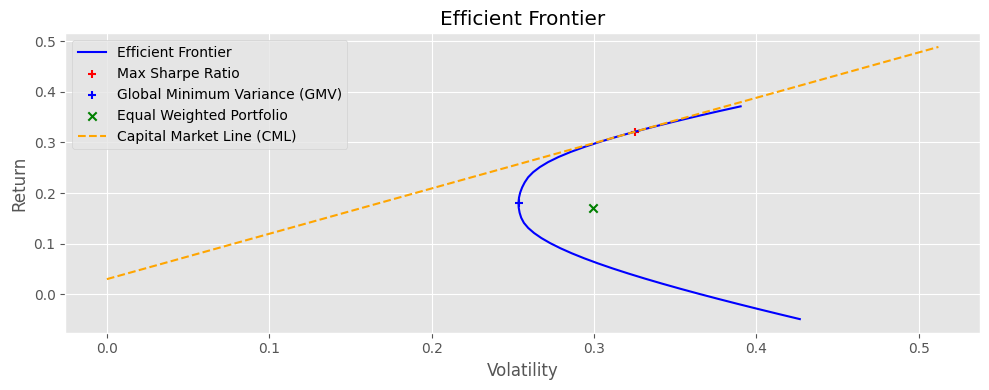

,Portfolio,Volatility,Return,Sharpe Ratio,INTC,GM,IBM,GE,F
0,Max Sharpe Ratio,0.325209,0.321076,0.895043,0.000000,0.000000,0.292365,0.707635,0.000000
1,Global Minimum Variance,0.253502,0.181076,0.595956,0.095133,0.027638,0.734875,0.081325,0.061030
2,Equal Weighted,0.299121,0.169771,0.467273,0.200000,0.200000,0.200000,0.200000,0.200000


In [201]:
EfficientFrontier(Tickers, PriceType, Period, Interval, RiskFreeRate=0.03, Step=0.01)

---
### XXI — Constant Proportion Portfolio Insurance (CPPI)

In [202]:
def CPPI(RiskyAsset, SafeAsset, PriceType, Period, Interval, Start=100, Floor=0.8, M=3, Drawdown=None, Plot=True):
    """
    Implements a Constant Proportion Portfolio Insurance (CPPI) strategy.

    Parameters:
    - RiskyAsset: str, ticker of the risky asset.
    - SafeAsset: str, ticker of the safe asset.
    - PriceType: type of price.
    - Period: data period.
    - Interval: data interval.
    - Start: initial portfolio value.
    - Floor: floor value as a proportion of initial capital.
    - M: multiplier for risky asset allocation.
    - Drawdown: maximum tolerated drawdown percentage.

    Returns:
    - A DataFrame with portfolio values and asset weights over time.
    """
    # Get returns of risky and safe assets
    RiskyReturns = AssetsReturns(RiskyAsset, PriceType, Period, Interval)
    SafeReturns = AssetsReturns(SafeAsset, PriceType, Period, Interval)

    # Ensure indices are aligned
    if not RiskyReturns.index.equals(SafeReturns.index):
        raise ValueError("Indices of RiskyReturns and SafeReturns are not aligned.")

    Dates = RiskyReturns.index
    RiskyRet = RiskyReturns[RiskyAsset].values
    SafeRet = SafeReturns[SafeAsset].values

    NumSteps = len(RiskyRet)
    PortfolioValues = np.zeros(NumSteps + 1)
    PortfolioValues[0] = Start
    FloorValue = Start * Floor
    RiskyWeights = np.zeros(NumSteps)
    SafeWeights = np.zeros(NumSteps)

    MaxValue = Start  # Track maximum portfolio value for drawdown calculation

    for t in range(NumSteps):
        # Calculate cushion
        Cushion = max(PortfolioValues[t] - FloorValue, 0)
        RiskyAlloc = min(M * Cushion, PortfolioValues[t])
        SafeAlloc = PortfolioValues[t] - RiskyAlloc

        # Calculate weights
        if PortfolioValues[t] > 0:
            RiskyWeight = RiskyAlloc / PortfolioValues[t]
            SafeWeight = 1 - RiskyWeight
        else:
            RiskyWeight = 0
            SafeWeight = 1

        RiskyWeights[t] = RiskyWeight
        SafeWeights[t] = SafeWeight

        # Update portfolio value
        PortfolioValues[t+1] = PortfolioValues[t] * (RiskyWeight * (1 + RiskyRet[t]) + SafeWeight * (1 + SafeRet[t]))

        # Apply floor constraint
        PortfolioValues[t+1] = max(PortfolioValues[t+1], FloorValue)

        # Update maximum portfolio value
        MaxValue = max(MaxValue, PortfolioValues[t+1])

        # Calculate drawdown
        CurrentDrawdown = (MaxValue - PortfolioValues[t+1]) / MaxValue

        # Adjust weights if drawdown exceeds threshold
        if Drawdown is not None and CurrentDrawdown > Drawdown:
            SafeWeights[t] = 1  # Allocate 100% to safe asset
            RiskyWeights[t] = 0  # Remove risky asset allocation
            PortfolioValues[t+1] = PortfolioValues[t] * (1 + SafeRet[t])  # Recalculate portfolio value

    # Build DataFrame with portfolio values and asset weights
    InitialDate = Dates[0] - (Dates[1] - Dates[0])
    AllDates = np.append([InitialDate], Dates)

    CPPI_DF = pd.DataFrame({
        'Portfolio Value': PortfolioValues,
        RiskyAsset: np.append([0], RiskyWeights),
        SafeAsset: np.append([1], SafeWeights)
    }, index=AllDates)
    
    if Plot == True:
        # Plot asset weights over time
        plt.figure(figsize=(12, 4))
        plt.title(f"CPPI Strategy (Floor: {Floor} ; M: {M}) Asset Weights Over Time")
        plt.plot(CPPI_DF[RiskyAsset], label=RiskyAsset)
        plt.plot(CPPI_DF[SafeAsset], label=SafeAsset)
        plt.legend()
        plt.show()

    return CPPI_DF

In [261]:
RiskyAsset= 'F'       
SafeAsset= 'IBM'
Start = 100
Floor = .75
M= 4
Drawdown = False

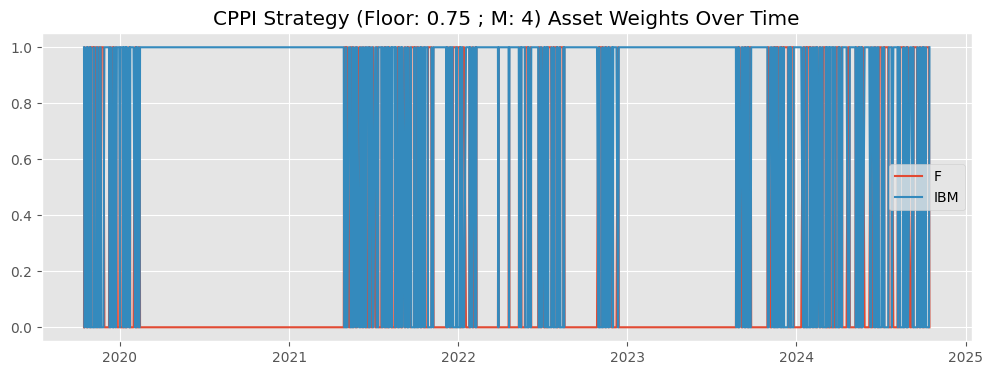

In [262]:
CPPI_DF = CPPI(RiskyAsset, SafeAsset, PriceType, Period, Interval, Start, Floor, M, Drawdown, Plot = True)

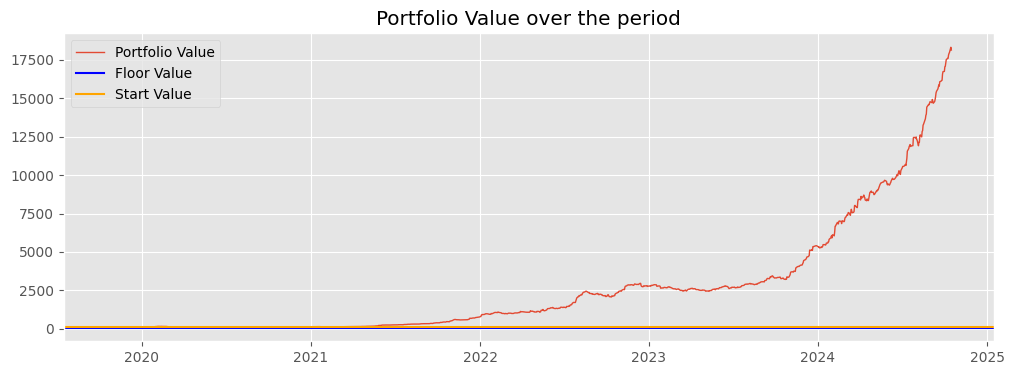

In [271]:
plt.figure(figsize=(12,4))
plt.plot(CPPI_DF['Portfolio Value'], label='Portfolio Value', linewidth=1)
plt.axhline(y=Floor*Start, label='Floor Value', color= 'blue')
plt.axhline(y=Start, label='Start Value', color ='orange')
plt.title(label='Portfolio Value over the period')
plt.legend()
plt.show()

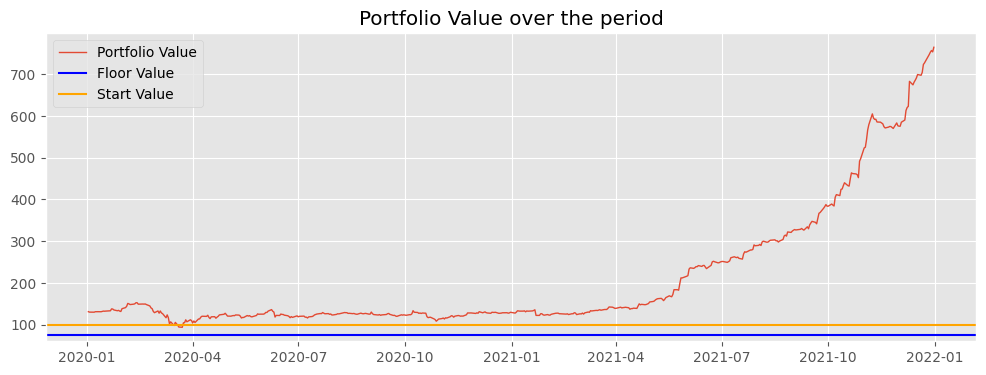

In [272]:
plt.figure(figsize=(12,4))
plt.plot(CPPI_DF['Portfolio Value']["2020":'2021'], label='Portfolio Value', linewidth=1)
plt.axhline(y=Floor*Start, label='Floor Value', color= 'blue')
plt.axhline(y=Start, label='Start Value', color ='orange')
plt.title(label='Portfolio Value over the period')
plt.legend()
plt.show()

--- 
### XXII — Simulation of Geometric Brownian Motion for prices trajectories

In [205]:
def GeometricBrownianMotion(NYears=10, NScenarios=1000, Mu=0.07, Sigma=0.15, StepsPerYear=12, S0=100.0, Prices=True):
    """
    Simulates Geometric Brownian Motion (GBM) trajectories.

    Parameters:
    - NYears: number of years to simulate.
    - NScenarios: number of scenarios to generate.
    - Mu: expected annual return.
    - Sigma: expected annual volatility.
    - StepsPerYear: number of time steps per year.
    - S0: initial asset value.
    - Prices: if True, returns prices; otherwise, returns returns.

    Returns:
    - A NumPy array of simulated prices or returns.
    """
    Dt = 1 / StepsPerYear
    NSteps = int(NYears * StepsPerYear) + 1

    # Generate standard normal random numbers
    Z = np.random.normal(size=(NSteps, NScenarios))
    # Calculate log returns
    Rets = (Mu - 0.5 * Sigma ** 2) * Dt + Sigma * np.sqrt(Dt) * Z
    Rets[0, :] = 0  # Initial return is zero
    # Cumulative log returns
    LogPrices = np.cumsum(Rets, axis=0)
    # Calculate prices
    PricesMatrix = S0 * np.exp(LogPrices)

    if Prices:
        return PricesMatrix
    else:
        # Returns are percentage changes in prices
        ReturnsMatrix = np.exp(Rets) - 1
        return ReturnsMatrix

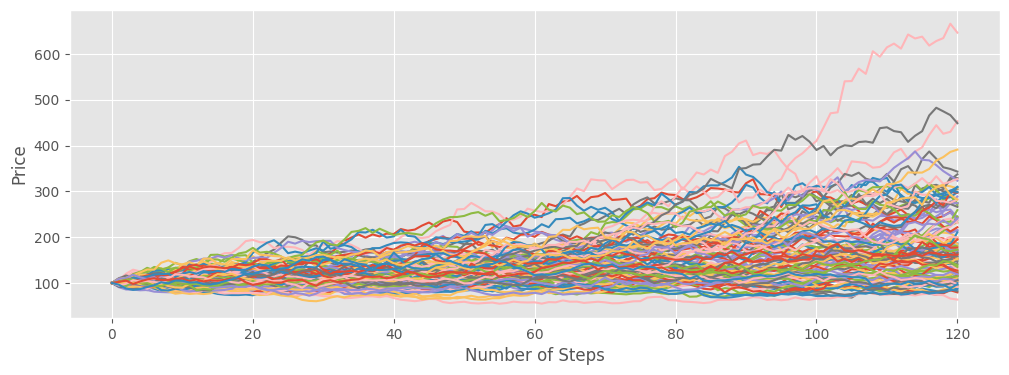

In [274]:
GeometricBrownianMotion(NYears=10, NScenarios=100, Mu=0.07, Sigma=0.15, StepsPerYear=12, S0=100.0, Prices=True)

plt.figure(figsize=(12,4))
plt.plot(SimulatedPrices)
plt.ylabel('Price')
plt.xlabel('Number of Steps')
plt.show()

--- 
### XXIII — CPPI Strategy with simulated prices

In [207]:
def CPPIStrategy(NYears=10, NScenarios=1000, Mu=0.07, Sigma=0.15, S0=100.0, StepsPerYear=12,M=3, Floor=0.8, RiskFreeRate=0.03):
    """
    Simulates a Constant Proportion Portfolio Insurance (CPPI) strategy.

    Parameters:
    - NYears: number of years to simulate.
    - NScenarios: number of scenarios to generate.
    - Mu: expected annual return of the risky asset.
    - Sigma: expected annual volatility of the risky asset.
    - S0: initial wealth.
    - StepsPerYear: number of time steps per year.
    - M: multiplier applied to the cushion to determine exposure to the risky asset.
    - Floor: minimum acceptable wealth level (as a proportion of initial wealth).
    - RiskFreeRate: annual risk-free rate.

    Returns:
    - None. Displays a plot of wealth over time and terminal wealth distribution.
    """
    Dt = 1 / StepsPerYear
    NSteps = int(NYears * StepsPerYear) + 1
    FloorValue = Floor * S0

    # Simulate risky asset prices
    RiskyPrices = GeometricBrownianMotion(NYears, NScenarios, Mu, Sigma, StepsPerYear, S0, Prices=True)
    # Risk-free return per time step
    RiskFreePerStep = (1 + RiskFreeRate) ** Dt

    # Initialize arrays
    Wealth = np.full((NSteps, NScenarios), S0)
    AllocRisky = np.zeros_like(Wealth)
    AllocSafe = np.zeros_like(Wealth)

    for Step in range(1, NSteps):
        # Calculate cushion
        Cushion = np.maximum(Wealth[Step - 1] - FloorValue, 0)
        # Allocate to risky asset
        Allocation = np.minimum(M * Cushion, Wealth[Step - 1])
        AllocRisky[Step] = Allocation
        # Allocate to risk-free asset
        AllocSafe[Step] = Wealth[Step - 1] - Allocation

        # Risky asset returns
        RiskyReturn = (RiskyPrices[Step] / RiskyPrices[Step - 1]) - 1
        # Update wealth
        Wealth[Step] = Allocation * (1 + RiskyReturn) + AllocSafe[Step] * RiskFreePerStep

    # Analyze results
    TerminalWealth = Wealth[-1, :]
    MeanTerminal = np.mean(TerminalWealth)
    MedianTerminal = np.median(TerminalWealth)
    Failures = TerminalWealth < FloorValue
    NFailures = np.sum(Failures)
    ProbFailure = (NFailures / NScenarios) * 100
    ExpectedShortfall = np.mean(FloorValue - TerminalWealth[Failures]) if NFailures > 0 else 0

    # Plotting
    Fig, (Ax1, Ax2) = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [4, 3]}, sharey=True)
    plt.subplots_adjust(wspace=0)

    MaxPlots = 500
    if NScenarios > MaxPlots:
        Indices = np.random.choice(NScenarios, MaxPlots, replace=False)
        Ax1.plot(Wealth[:, Indices], linewidth=0.5)
    else:
        Ax1.plot(Wealth, linewidth=0.5)

    Ax1.axhline(y=S0, ls="--", color='green', label='Initial Wealth (S₀)')
    Ax1.axhline(y=FloorValue, ls="--", color='red', label=f'Floor (S₀ × {Floor})')
    Ax1.set_xlabel('Time Steps')
    Ax1.set_ylabel('Wealth')
    Ax1.set_title('CPPI Strategy Simulation')
    Ax1.legend()

    # Histogram of terminal wealth
    Ax2.hist(TerminalWealth, bins=50, edgecolor='black', orientation='horizontal')
    Ax2.axhline(y=FloorValue, ls="--", color='red', label='Floor')
    Ax2.set_xlabel('Frequency')
    Ax2.set_title('Terminal Wealth Distribution')

    # Annotate statistics
    StatsText = (
        f"Mean: {MeanTerminal:.2f}\n"
        f"Median: {MedianTerminal:.2f}\n"
        f"Failures: {NFailures} ({ProbFailure:.2f}%)\n"
        f"Expected Shortfall: {ExpectedShortfall:.2f}"
    )
    Ax2.annotate(StatsText, xy=(0.95, 0.95), xycoords='axes fraction', fontsize=10,
                 horizontalalignment='right', verticalalignment='top')

    plt.show()

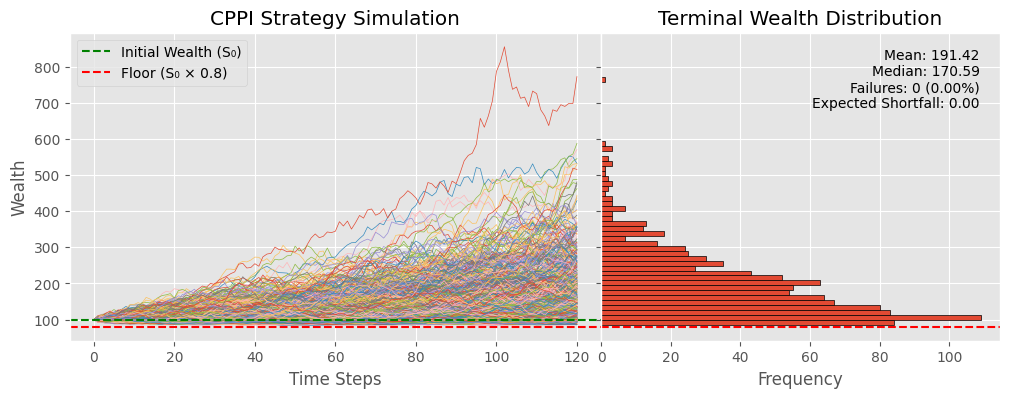

In [208]:
CPPIStrategy(NYears=10, NScenarios=1000, Mu=0.07, Sigma=0.15, S0=100.0, StepsPerYear=12,M=3, Floor=0.8, RiskFreeRate=0.03)

--- 
### XXIV — Interactive CPPI Strategy with simulated prices

In [209]:
def CPPIWithWidgets():
    """
    Interactive CPPI strategy simulation using widgets.

    Allows the user to adjust parameters and visualize the results.
    """
    CPPIControls = widgets.interactive(
        CPPIStrategy,
        NYears=widgets.FloatSlider(min=0.5, max=10, step=0.5, value=1, description='Years'),
        NScenarios=widgets.IntSlider(min=500, max=10000, step=500, value=500, description='Scenarios'),
        Mu=widgets.FloatSlider(min=0.01, max=0.2, step=0.01, value=0.07, description='Drift (μ)'),
        Sigma=widgets.FloatSlider(min=0.05, max=1, step=0.01, value=0.15, description='Volatility (σ)'),
        S0=widgets.FloatSlider(min=0, max=10000, step=100, value=100, description='Initial Wealth (S₀)'),
        StepsPerYear=widgets.IntSlider(min=1, max=504, step=1, value=36, description='Steps per Year'),
        M=widgets.FloatSlider(min=1, max=10, step=0.5, value=3, description='Multiplier (M)'),
        Floor=widgets.FloatSlider(min=0.3, max=0.8, step=0.05, value=0.8, description='Floor (S₀ × %)'),
        RiskFreeRate=widgets.FloatSlider(min=0.0, max=0.05, step=0.005, value=0.03, description='Risk-Free Rate (r)')
    )

    display(CPPIControls)

In [210]:
CPPIWithWidgets()

interactive(children=(FloatSlider(value=1.0, description='Years', max=10.0, min=0.5, step=0.5), IntSlider(valu…